# Intro/Imports
This is going to be a more granular, customizable neural net.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import joblib
import pathlib as path
import copy

# Data Read-in
unchanged from neuralnet.ipynb; this is non-negotiable. 
For any of the user changes to work, I need to know the shape of the data; so this split will be universal. 

In [22]:
rawData = pd.read_csv('STEMVisualsSynthData.csv', header=0)
#remove unneeded column
rawData.drop('Index_within_Experiment', axis = 1, inplace = True)
#X is inputs--the three Concentrations, F_in, I0 (light intensity), and c_N_in (6)
X = rawData[['Time', 'C_X', 'C_N', 'C_L', 'F_in', 'C_N_in', 'I0']]
Y = X.copy(deep=True)
#drop unnecessary rows in Y
Y.drop('F_in', axis = 1, inplace = True)
Y.drop('C_N_in', axis = 1, inplace = True)
Y.drop('I0', axis = 1, inplace = True)
Y.drop('Time', axis = 1, inplace = True)
#Y vals should be X concentrations one timestep ahead, so remove the first index
Y.drop(index=0, inplace=True)
#To keep the two consistent, remove the last index of X
X.drop(index=19999, inplace=True)

#initalize array used to store model creation parameters
mp = {'Optimizer': [1], 'Loss': [0], 'LearnRate':[0.0005]}
modelParams = pd.DataFrame(data=mp)
#what row of modelParams to reference
paramVal = 0

C:\Users\kenda\AppData\Local\Temp\ipykernel_15420\3387194111.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(index=19999, inplace=True)


# Train/Test Split
Keeping it simple stupid, there's only 1 split happening here. User chooses the percentage of data to hold out for testing.

In [23]:
#defaults
train_ratio = 0.8
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - train_ratio)

#Separate Time out--we don't want this as a feature the model learns (since it's already incorporated in by how X and Y are structured!)
#however, having the time values will be useful for plotting later
XTrainTime = X_train.pop('Time')
XTestTime = X_test.pop('Time')

# Preprocessing
Another thing I'm going to just have to have happen backend without the user's input.

In [24]:
#for both x and y, create a min max scaler
mmscalerX = preprocessing.MinMaxScaler()
#we'll fit and transform based on training data
X_train_minmax = mmscalerX.fit_transform(X_train)
#transform testing data based on training data
X_test_minmax = mmscalerX.transform(X_test)
#same process as above for Y
mmscalerY = preprocessing.MinMaxScaler()
Y_train_minmax = mmscalerY.fit_transform(Y_train)
Y_test_minmax = mmscalerY.transform(Y_test)

# Tensor Creation

In [25]:
#put our data into tensors
X_train = torch.tensor(X_train_minmax, dtype=torch.float32)
y_train = torch.tensor(Y_train_minmax, dtype=torch.float32)
X_test = torch.tensor(X_test_minmax, dtype=torch.float32)
y_test = torch.tensor(Y_test_minmax, dtype=torch.float32)

# Model Creation
Here's where the majority of new stuff comes in--we need to let the user have control over a lot of things.
- Num Nodes: How many hidden nodes per layer? range: 5-20
- Optimizer: How does the model update its weights? choices: ADAM, SGD
- Loss: How does the model measure accuracy? choices: L1, MSE, LKDivLoss
- Learning Rate: How greatly can the optimizer change weights? range: 0.00001-0.1
- Epochs: How many times to run the training data through the model? range: 10-1000

In [26]:
numNodes = 20
#set up the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], numNodes),
    nn.ReLU(),
    nn.Linear(numNodes, numNodes),
    nn.ReLU(),
    nn.Linear(numNodes, y_train.shape[1]),
)
lossChoice = modelParams['Loss'][paramVal]
#set up the loss function
match lossChoice:
    case 0:
        loss_fn = nn.MSELoss()
    case 1:
        loss_fn = nn.KLDivLoss()
    case _:
        print("Invalid loss function choice. Defaulting to MSE.")
        loss_fn = nn.MSELoss()

#set up the optimizer
optimChoice = modelParams['Optimizer'][paramVal]
lr = modelParams['LearnRate'][paramVal]
match optimChoice:
    case 0:
        optimizer = optim.SGD(model.parameters(), lr=lr)
    case 1:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    case _:
        print("Invalid optimizer choice. Defaulting to SGD.")
        optimizer = optim.SGD(model.parameters(), lr=lr)



# Training
Mostly unchanged. User can change:
- num of Epochs, range: 10-1000
- Batch size, range: 100-1000

In [27]:
# training parameters
n_epochs = 100
batch_size = 100
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

# Loss Graph
(unchanged)

MSE: 0.00
RMSE: 0.04


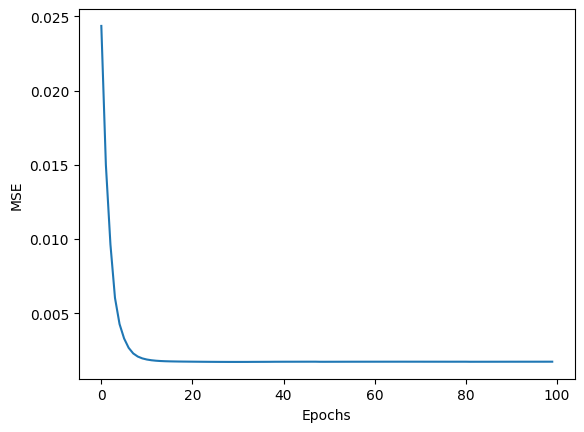

In [28]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

# Visualization
- TODO: COME BACK LATER. This is just to see inside the model, want to implement in Bokeh.

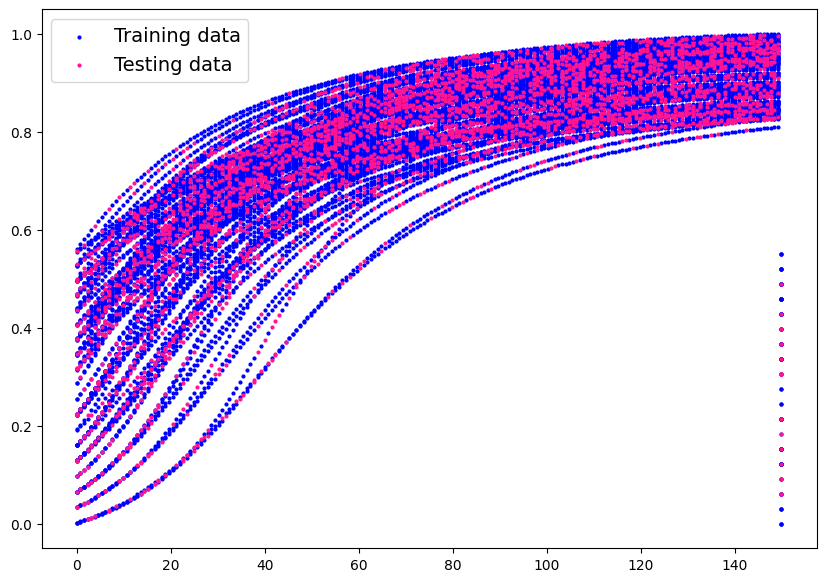

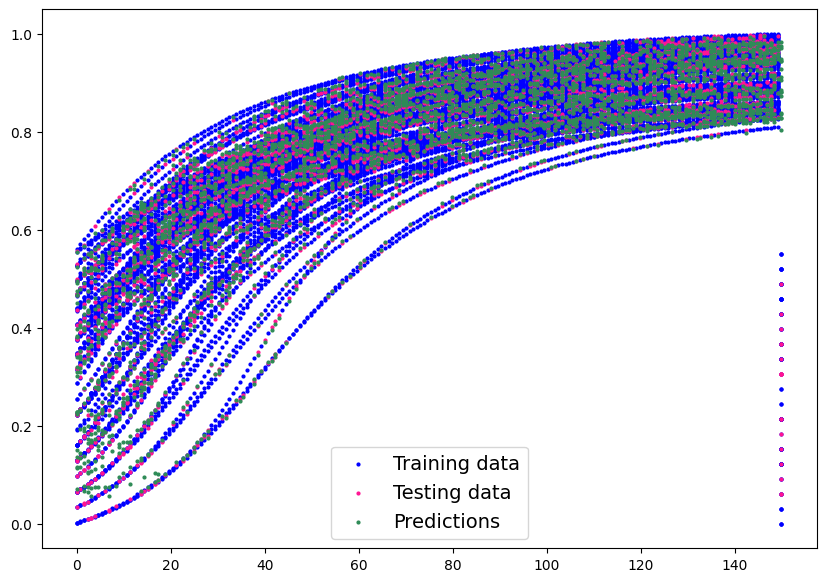

In [29]:
#quick visual just to see our data
def plot_predictions(train_data=XTrainTime, 
                     train_labels=y_train[:, 0], 
                     test_data=XTestTime, 
                     test_labels=y_test[:, 0], 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7)) #create the base of our figure, figsize feeds in width/height in inches

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data") #c for color, s for size. 
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="deeppink", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="seagreen", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions();
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  y_preds = model(X_test)
y_preds 
plot_predictions(predictions= torch.Tensor.cpu(y_preds[:, 0])) # gotta make sure that the model is on the cpu for this to work--this'll do nothing if already on cpu

# Export models
- saves to models folder in working directory, for use in another visualization script

In [30]:
torch.save(model, 'models/model.pt')
joblib.dump(mmscalerX, 'models/mmscalerX.pkl')
joblib.dump(mmscalerY, 'models/mmscalerY.pkl')

filepath = path.Path('outputs\modelLosses.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  
historydf = pd.DataFrame(history, columns=['Loss'])
historydf.to_csv(filepath, index=False)
